<a href="https://colab.research.google.com/github/CrowdSalat/ann-dynamical-systems/blob/master/predict_plane_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# predict plane state

Uses actions and a input state to predict the outputstate.

## imports

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [3]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

Using TensorFlow backend.


2.0.0-rc2


## load files

In [0]:
file0 = 'trainingsset_00.csv'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/My Drive/xplane_data' 
os.chdir(root_dir)
print ('working dir: ' + os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
working dir: /content/drive/My Drive/xplane_data


## actions & states
actions and states at time t are the input for the network.

the states at time t + 1 are the desired output of the network.


In [0]:
m_time      = '   missn,_time '
z_time      = '   _zulu,_time '
yaw_v       = '   ____Q,rad/s '
yaw_deg     = '   hding,_true '
roll_deg    = '   _roll,__deg '
roll_v      = '   ____R,rad/s '
pitch_deg   = '   pitch,__deg '
pitch_v     = '   ____P,rad/s '
alt         = '   __alt,ftmsl '
vv          = '   __VVI,__fpm '
v           = '   Vtrue,_ktas '
rpm_prop    = '   rpm_1,_prop '

# TODO add throt, part and throt, part2 to dataoutput		

state = [ 
          #m_time,
          #z_time,
          yaw_v,
          yaw_deg,
          roll_deg,
          roll_v,
          pitch_deg,
          pitch_v,
          vv,
          alt,
          v,
          rpm_prop,
          #TODO add throttle
        ]

In [0]:
elev_servo                  = '   _elev,servo '
ailrn_servo                  = '   ailrn,servo '
ruddr_servo                  = '   ruddr,servo '

actions = [
           elev_servo , 
           ailrn_servo, 
           ruddr_servo         
]

In [0]:
def load_xplane_csv(csv_path, columns):
    return pd.read_csv(csv_path, delimiter='|', usecols = columns, 
                       float_precision='high')

df_actions = load_xplane_csv(file0, actions)

df_states = load_xplane_csv(file0, state)

assert(len(df_actions) == len(df_states))


In [9]:
def get_labels_ownimpl(states_t0):
  '''
  remove first row 
  add new  np.nan row at the end
  prefix column names wih 'y_'
  '''
  states_t1 = states_t0.copy().drop(0)
  states_t1 = states_t1.add_suffix('_t+1')
  nan_row = pd.DataFrame(np.nan, index=[len(states_t1) + 1], columns=states_t1.columns)
  states_t1 = states_t1.append(nan_row)
  assert(states_t0.shape == states_t1.shape)
  return states_t1

def get_labels(features):
  return features[:].shift(-1).add_suffix('_t+1')

df_labels = get_labels(df_states)
print(df_labels.tail(2))


         Vtrue,_ktas _t+1  ...     rpm_1,_prop _t+1
6484            127.53832  ...           2604.68213
6485                  NaN  ...                  NaN

[2 rows x 10 columns]


In [0]:
def split_train_test(dataset):
  train_size = int(len(dataset) * 0.67)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
  return train, test


In [0]:
df_features = df_actions.join(df_states)
assert(len(df_features) == len(df_labels))

features = df_features.values
labels = df_labels.values

train_X, test_X = split_train_test(features)
train_Y, test_Y = split_train_test(labels)

In [1]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

NameError: ignored

In [35]:
features_nr = train_X.shape[1]
target_nr = train_Y.shape[1]


baseline_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    keras.layers.Dense(features_nr, activation='relu', 
                       input_shape=(features_nr,)),
    keras.layers.Dense(400, activation='relu'),
    keras.layers.Dense(400, activation='relu'),
    keras.layers.Dense(target_nr)
])

baseline_model.compile(optimizer='adam',
                       loss='mean_squared_error',
                       metrics=['accuracy', 'binary_crossentropy', 'mean_squared_error'])

baseline_model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_45 (Dense)             (None, 400)               5600      
_________________________________________________________________
dense_46 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_47 (Dense)             (None, 10)                4010      
Total params: 170,192
Trainable params: 170,192
Non-trainable params: 0
_________________________________________________________________


In [43]:
baseline_history = baseline_model.fit(train_X,
                                      train_Y,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_X, test_Y),
                                      verbose=2)


Train on 4345 samples, validate on 2141 samples
Epoch 1/20
4345/4345 - 0s - loss: 9.3323 - accuracy: 1.0000 - binary_crossentropy: -6.6663e+03 - mean_squared_error: 9.3323 - val_loss: nan - val_accuracy: 0.9995 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 2/20
4345/4345 - 0s - loss: 6.0379 - accuracy: 1.0000 - binary_crossentropy: -6.6670e+03 - mean_squared_error: 6.0379 - val_loss: nan - val_accuracy: 0.9995 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 3/20
4345/4345 - 0s - loss: 5.1040 - accuracy: 1.0000 - binary_crossentropy: -6.6681e+03 - mean_squared_error: 5.1040 - val_loss: nan - val_accuracy: 0.9995 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 4/20
4345/4345 - 0s - loss: 4.7419 - accuracy: 1.0000 - binary_crossentropy: -6.6686e+03 - mean_squared_error: 4.7419 - val_loss: nan - val_accuracy: 0.9995 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 5/20
4345/4345 - 0s - loss: 4.8404 - accuracy: 1.0

In [37]:
features_nr = train_X.shape[1]
target_nr = train_Y.shape[1]


bigger_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    keras.layers.Dense(features_nr, activation='relu', 
                       input_shape=(features_nr,)),
    keras.layers.Dense(1200, activation='relu'),
    keras.layers.Dense(600, activation='relu'),
    keras.layers.Dense(600, activation='relu'),
    keras.layers.Dense(target_nr)
])

bigger_model.compile(optimizer='adam',
                       loss='mean_squared_error',
                       metrics=['accuracy', 'binary_crossentropy', 'mean_squared_error'])

bigger_model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_49 (Dense)             (None, 1200)              16800     
_________________________________________________________________
dense_50 (Dense)             (None, 600)               720600    
_________________________________________________________________
dense_51 (Dense)             (None, 600)               360600    
_________________________________________________________________
dense_52 (Dense)             (None, 10)                6010      
Total params: 1,104,192
Trainable params: 1,104,192
Non-trainable params: 0
_________________________________________________________________


In [38]:
bigger_history = bigger_model.fit(train_X,
                                      train_Y,
                                      epochs=20,
                                      validation_data=(test_X, test_Y),
                                      verbose=2)


Train on 4345 samples, validate on 2141 samples
Epoch 1/20
4345/4345 - 3s - loss: 28945.4268 - accuracy: 1.0000 - binary_crossentropy: -6.5503e+03 - mean_squared_error: 28945.4219 - val_loss: nan - val_accuracy: 0.9995 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 2/20
4345/4345 - 2s - loss: 1971.0327 - accuracy: 1.0000 - binary_crossentropy: -6.6613e+03 - mean_squared_error: 1971.0330 - val_loss: nan - val_accuracy: 0.9995 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 3/20
4345/4345 - 2s - loss: 255.0240 - accuracy: 1.0000 - binary_crossentropy: -6.6668e+03 - mean_squared_error: 255.0240 - val_loss: nan - val_accuracy: 0.9995 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 4/20
4345/4345 - 2s - loss: 195.9120 - accuracy: 1.0000 - binary_crossentropy: -6.6667e+03 - mean_squared_error: 195.9120 - val_loss: nan - val_accuracy: 0.9995 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 5/20
4345/4345 - 2s - loss: 

In [39]:
features_nr = train_X.shape[1]
target_nr = train_Y.shape[1]


smaller_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    keras.layers.Dense(features_nr, activation='relu', 
                       input_shape=(features_nr,)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(target_nr)
])

smaller_model.compile(optimizer='adam',
                       loss='mean_squared_error',
                       metrics=['accuracy', 'binary_crossentropy', 'mean_squared_error'])

smaller_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_54 (Dense)             (None, 100)               1400      
_________________________________________________________________
dense_55 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_56 (Dense)             (None, 10)                1010      
Total params: 12,692
Trainable params: 12,692
Non-trainable params: 0
_________________________________________________________________


In [40]:
smaller_history = smaller_model.fit(train_X,
                                      train_Y,
                                      epochs=20,
                                      validation_data=(test_X, test_Y),
                                      verbose=2)


Train on 4345 samples, validate on 2141 samples
Epoch 1/20
4345/4345 - 1s - loss: 87656.8389 - accuracy: 1.0000 - binary_crossentropy: -6.4096e+03 - mean_squared_error: 87656.8594 - val_loss: nan - val_accuracy: 0.9995 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 2/20
4345/4345 - 0s - loss: 1450.7840 - accuracy: 1.0000 - binary_crossentropy: -6.6594e+03 - mean_squared_error: 1450.7842 - val_loss: nan - val_accuracy: 0.9995 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 3/20
4345/4345 - 0s - loss: 259.2105 - accuracy: 1.0000 - binary_crossentropy: -6.6662e+03 - mean_squared_error: 259.2105 - val_loss: nan - val_accuracy: 0.9995 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 4/20
4345/4345 - 0s - loss: 172.6628 - accuracy: 1.0000 - binary_crossentropy: -6.6668e+03 - mean_squared_error: 172.6628 - val_loss: nan - val_accuracy: 0.9995 - val_binary_crossentropy: nan - val_mean_squared_error: nan
Epoch 5/20
4345/4345 - 0s - loss: 

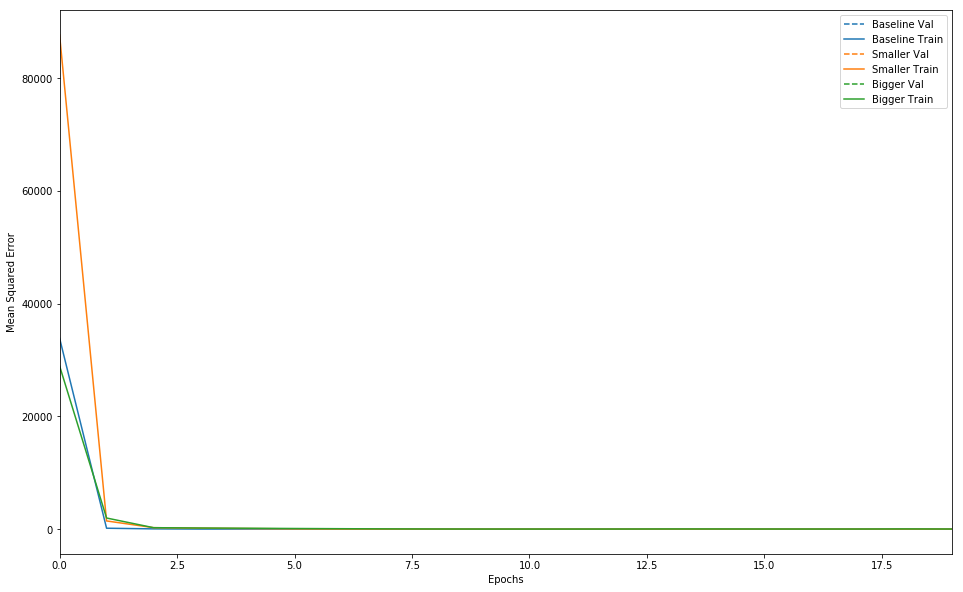

In [41]:
def plot_history(histories, key='mean_squared_error'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])
